## Relax - Data Science Take Home Challenge

Task: Defining  an  "adopted  user"   as  a  user  who   has  logged  into  the  product  on  three  separate
days  in  at  least  one  seven-day  period ,  identify  which  factors  predict  future  user
adoption .


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from pandas import MultiIndex, Int16Dtype # by putting this, we can get rid of the warning of int64Index
import xgboost as xgb
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

C:\Users\anita\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


### A usage  summary table

In [2]:
df_engagement = pd.read_csv('takehome_user_engagement.csv')

In [3]:
df_engagement.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


In [4]:
df_engagement.shape

(207917, 3)

In [5]:
df_engagement.dtypes

time_stamp    object
user_id        int64
visited        int64
dtype: object

In [6]:
df_engagement.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 207917 entries, 0 to 207916
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   time_stamp  207917 non-null  object
 1   user_id     207917 non-null  int64 
 2   visited     207917 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.8+ MB


No Null values

In [7]:
df_engagement = df_engagement.set_index(pd.DatetimeIndex(df_engagement['time_stamp']))

In [8]:
df_engagement.head()

,time_stamp,user_id,visited
time_stamp,,,
2014-04-22 03:53:30,2014-04-22 03:53:30,1,1
2013-11-15 03:45:04,2013-11-15 03:45:04,2,1
2013-11-29 03:45:04,2013-11-29 03:45:04,2,1
2013-12-09 03:45:04,2013-12-09 03:45:04,2,1
2013-12-25 03:45:04,2013-12-25 03:45:04,2,1


In [9]:
#groups by user, then date by week, and sums number of visits per week
grouped = df_engagement.groupby('user_id').resample('1W').sum()


In [10]:
grouped[grouped['user_id'].isnull()]

,,user_id,visited
user_id,time_stamp,,


In [11]:
grouped.shape

(82282, 2)

In [12]:
#removes weeks that were imputed for grouping but are NaN
grouped = grouped[grouped['user_id'].isnull()==False].drop('user_id',axis=1)
grouped.head(20)

visited
user_id time_stamp         
1       2014-04-27        1
2       2013-11-17        1
        2013-11-24        0
        2013-12-01        1
        2013-12-08        0
        2013-12-15        1
        2013-12-22        0
        2013-12-29        1
        2014-01-05        1
        2014-01-12        1
        2014-01-19        0
        2014-01-26        0
        2014-02-02        0
        2014-02-09        3
        2014-02-16        2
        2014-02-23        0
        2014-03-02        0
        2014-03-09        1
        2014-03-16        1
        2014-03-23        0

In [13]:
grouped['visited'] >= 3

user_id  time_stamp
1        2014-04-27    False
2        2013-11-17    False
         2013-11-24    False
         2013-12-01    False
         2013-12-08    False
                       ...  
11996    2013-09-08    False
11997    2013-01-20    False
11998    2014-04-27    False
11999    2012-06-03    False
12000    2014-01-26    False
Name: visited, Length: 82282, dtype: bool

In [14]:
#tags weeks that had less than 3 visits for all users#tags w 
active_users = grouped['visited'] >= 3


In [15]:
#Groups by users and sums up the number of weeks that had 3 or more visits
#level =0 - grouping the the first index which is user_id
active_users = active_users.groupby(level=0).apply(np.sum)


In [16]:
active_users.head()

user_id
1    0
2    1
3    0
4    0
5    0
Name: visited, dtype: int64

In [17]:
#removes users with no weeks that had 3 or more visits
active_users = active_users[active_users!=0]


In [18]:
active_users.head()

user_id
2      1
10    52
20     1
33     1
42    68
Name: visited, dtype: int64

In [19]:
type(active_users)

pandas.core.series.Series

convert this active_users to a dataframe

In [20]:
active_users = pd.DataFrame(active_users,index=active_users.index)
active_users.head()

,visited
user_id,
2,1
10,52
20,1
33,1
42,68


In [21]:
active_users.columns = ['Active Weeks']
active_users.head(5)

,Active Weeks
user_id,
2,1
10,52
20,1
33,1
42,68


In [22]:
active_users.shape

(1445, 1)

###  user  table

In [23]:
df_users = pd.read_csv('takehome_users.csv',encoding='latin-1')

I was getting error as UnicodeDecode error. Based on stackoverflow, I have to keep encoding =latin-1
https://stackoverflow.com/questions/5552555/unicodedecodeerror-invalid-continuation-byte

In [24]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0


In [25]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 10 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   object_id                   12000 non-null  int64  
 1   creation_time               12000 non-null  object 
 2   name                        12000 non-null  object 
 3   email                       12000 non-null  object 
 4   creation_source             12000 non-null  object 
 5   last_session_creation_time  8823 non-null   float64
 6   opted_in_to_mailing_list    12000 non-null  int64  
 7   enabled_for_marketing_drip  12000 non-null  int64  
 8   org_id                      12000 non-null  int64  
 9   invited_by_user_id          6417 non-null   float64
dtypes: float64(2), int64(4), object(4)
memory usage: 937.6+ KB


null values observed for last_session_creation_time and invited_by_user_id columns. There are 12000 observations

### Merge Data

In [26]:
active_user_data = active_users.merge(df_users,left_index=True,right_on='object_id',how='inner')
active_user_data.head()

,Active Weeks,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id
1,1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0
9,52,10,2013-01-16 22:08:03,Santos Carla,CarlaFerreiraSantos@gustr.com,ORG_INVITE,1.401833e+09,1,1,318,4143.0
19,1,20,2014-03-06 11:46:38,Helms Mikayla,lqyvjilf@uhzdq.com,SIGNUP,1.401364e+09,0,0,58,NaN
32,1,33,2014-03-11 06:29:09,Araujo José,JoseMartinsAraujo@cuvox.de,GUEST_INVITE,1.401518e+09,0,0,401,79.0
41,68,42,2012-11-11 19:05:07,Pinto Giovanna,GiovannaCunhaPinto@cuvox.de,SIGNUP,1.401045e+09,1,0,235,NaN


In [27]:
active_user_data.shape #expecting 1445 records since it is an inner join

(1445, 11)

In [28]:
#Pull data on Active users
active_user_data['Active']=1




In [29]:
#Add Active column to df_users
df_users['Active']=int(0)


In [30]:
df_users.head()

,object_id,creation_time,name,email,creation_source,last_session_creation_time,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
0,1,2014-04-22 03:53:30,Clausen August,AugustCClausen@yahoo.com,GUEST_INVITE,1.398139e+09,1,0,11,10803.0,0
1,2,2013-11-15 03:45:04,Poole Matthew,MatthewPoole@gustr.com,ORG_INVITE,1.396238e+09,0,0,1,316.0,0
2,3,2013-03-19 23:14:52,Bottrill Mitchell,MitchellBottrill@gustr.com,ORG_INVITE,1.363735e+09,0,0,94,1525.0,0
3,4,2013-05-21 08:09:28,Clausen Nicklas,NicklasSClausen@yahoo.com,GUEST_INVITE,1.369210e+09,0,0,1,5151.0,0
4,5,2013-01-17 10:14:20,Raw Grace,GraceRaw@yahoo.com,GUEST_INVITE,1.358850e+09,0,0,193,5240.0,0


In [31]:
np.ravel(list(active_user_data.index))

array([    1,     9,    19, ..., 11968, 11974, 11987])

In [32]:
df_users.iloc[list(active_user_data.index),10]=1


The above code will assign the value of 1 to the tenth column which is Active

In [33]:
model_data = df_users.set_index('object_id').sort_index()

In [34]:
#Prep data for modeling by removing unecessary features
model_data = model_data.drop([ 'name', 'email','last_session_creation_time',],axis=1)


In [35]:
date_feature = model_data.pop('creation_time')


In [36]:
date_feature

object_id
1        2014-04-22 03:53:30
2        2013-11-15 03:45:04
3        2013-03-19 23:14:52
4        2013-05-21 08:09:28
5        2013-01-17 10:14:20
                ...         
11996    2013-09-06 06:14:15
11997    2013-01-10 18:28:37
11998    2014-04-27 12:45:16
11999    2012-05-31 11:55:59
12000    2014-01-26 08:57:12
Name: creation_time, Length: 12000, dtype: object

In [37]:
model_data.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active
object_id,,,,,,
1,GUEST_INVITE,1,0,11,10803.0,0
2,ORG_INVITE,0,0,1,316.0,1
3,ORG_INVITE,0,0,94,1525.0,0
4,GUEST_INVITE,0,0,1,5151.0,0
5,GUEST_INVITE,0,0,193,5240.0,0


In [38]:
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].fillna(0)
model_data['invited_by_user_id'] = model_data['invited_by_user_id'].apply(
        lambda x: 1 if x!=0 else 0)
model_data = pd.get_dummies(data=model_data,columns=['creation_source'])

In [39]:
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
object_id,,,,,,,,,,
1,1,0,11,1,0,1,0,0,0,0
2,0,0,1,1,1,0,1,0,0,0
3,0,0,94,1,0,0,1,0,0,0
4,0,0,1,1,0,1,0,0,0,0
5,0,0,193,1,0,1,0,0,0,0


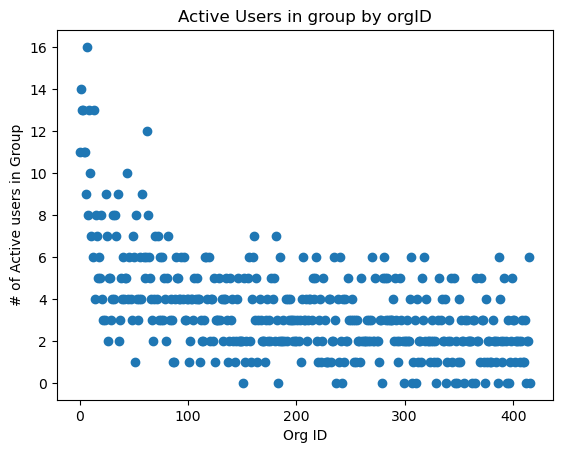

In [40]:

org = model_data.groupby('org_id').sum()
plt.scatter(org.index,org.Active)
plt.ylabel('# of Active users in Group')
plt.xlabel('Org ID')
plt.title('Active Users in group by orgID')
plt.show()

In [41]:
org.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH
org_id,,,,,,,,,
0,77,42,159,11,55,104,68,51,41
1,45,20,119,14,38,81,52,27,35
2,36,27,100,13,32,68,31,42,28
3,41,16,102,13,32,70,24,24,18
4,45,25,94,11,37,57,22,23,20


In [42]:
org_cata = []
for i in model_data['org_id']:
    cata = org.loc[i,'Active']
    org_cata.append(cata)
model_data['org_id'] = org_cata

model_data = pd.get_dummies(data=model_data,columns=['org_id'])
model_data.head()

,opted_in_to_mailing_list,enabled_for_marketing_drip,invited_by_user_id,Active,creation_source_GUEST_INVITE,creation_source_ORG_INVITE,creation_source_PERSONAL_PROJECTS,creation_source_SIGNUP,creation_source_SIGNUP_GOOGLE_AUTH,org_id_0,...,org_id_6,org_id_7,org_id_8,org_id_9,org_id_10,org_id_11,org_id_12,org_id_13,org_id_14,org_id_16
object_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,1,0,1,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,0,0,1,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
3,0,0,1,0,0,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
4,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
5,0,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [43]:


y = model_data.pop('Active')
x = model_data

In [44]:
X_train,X_test,y_train,y_test = train_test_split(x, y, test_size = 0.25,random_state=42,stratify=y)

In [45]:
X_train.shape,X_test.shape,y_train.shape,y_test.shape

((9000, 24), (3000, 24), (9000,), (3000,))

In [46]:
y_train.value_counts()

0    7916
1    1084
Name: Active, dtype: int64

In [47]:
y_test.value_counts()

0    2639
1     361
Name: Active, dtype: int64

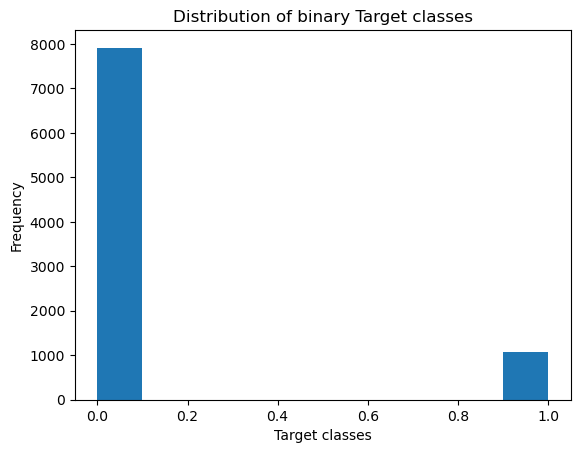

In [48]:
ax=y_train.hist(grid=False)
ax.set_xlabel('Target classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of binary Target classes')
plt.show()

In [49]:
from imblearn.over_sampling import SMOTE
from collections import Counter

In [50]:
#Binary SMOTE the training data
sm = SMOTE(random_state=1)
X_2_bal, y_2_bal = sm.fit_resample(X_train, y_train)

In [51]:
print('y_train before SMOTE  %s' % Counter(y_train))

y_train before SMOTE  Counter({0: 7916, 1: 1084})


In [52]:
print('y_train AFTER SMOTE  %s' % Counter(y_2_bal))

y_train AFTER SMOTE  Counter({0: 7916, 1: 7916})


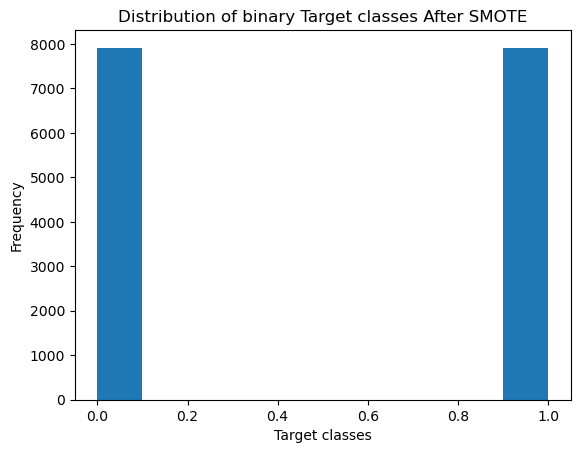

In [53]:
ax=y_2_bal.hist(grid=False)
ax.set_xlabel('Target classes')
ax.set_ylabel('Frequency')
ax.set_title('Distribution of binary Target classes After SMOTE')
plt.show()

#### imbalanced target values

In [54]:
def tune_hyperparameters(clf, param_grid, X_train, y_train):
    """
    This function tunes the hyperparameters of a classifier using GridSearchCV and cross-validation
    and returns the best classifier model with the optimal hyperparameters.
    """
    
    # Create the cross-validation object using StratifiedKFold to ensure the class distribution is the same across all the folds
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

    # Create the GridSearchCV object
    clf_grid = GridSearchCV(clf, param_grid, cv=cv, scoring='accuracy', n_jobs=-1)

    # Fit the GridSearchCV object to the training data
    clf_grid.fit(X_train, y_train)

    # Get the best hyperparameters
    print("Best hyperparameters:\n", clf_grid.best_params_)
    
    # Return best_estimator_ attribute which gives us the best model that has been fitted to the training data
    return clf_grid.best_estimator_

In [55]:
# Define the hyperparameter grid to search
xgb_param_grid = {
    'max_depth': [5, 6, 7],
    'learning_rate': [0.04, 0.05, 0.06],
    'n_estimators': [150, 200, 250],
    'min_child_weight': [2, 3, 4],
    'scale_pos_weight': [0.2, 0.5, 0.8],
    'subsample': [0.8, 0.9, 1],  
    'colsample_bytree': [0.3, 0.5, 0.8],
    'colsample_bylevel': [0.7, 0.8, 0.9], 
    'reg_alpha': [0.01, 0.05, 0.1],  
    'reg_lambda': [0.05, 0.1, 0.2], 
    'max_delta_step': [1, 2, 3],    
    'gamma': [0, 0.1, 0.2]
}

In [56]:
# Initialize the XGBoost Classifier
#xgb_clf = xgb.XGBClassifier(random_state=0)


In [57]:
# Find the best hyperparameters
#xgb_opt = tune_hyperparameters(xgb_clf, xgb_param_grid, X_train, y_train)
# I interrupted this as it was taking a very ling time. ALmost four hours it ran

In [58]:
# Initialize the XGBoost Classifier using optimal hyperparameters
xgb_opt = xgb.XGBClassifier(max_depth=6,
                        learning_rate=0.05,
                        n_estimators=200,  
                        min_child_weight=2,
                        scale_pos_weight=0.5,
                        subsample=0.9 ,
                        colsample_bytree=0.5,
                        colsample_bylevel=0.8 ,
                        reg_alpha=0.05 ,
                        reg_lambda=0.1 ,
                        max_delta_step=2 ,
                        gamma=0.1,
                            use_label_encoder =False,
                        random_state=0)

# Train the XGBoost classifier
xgb_opt.fit(X_2_bal, y_2_bal)

C:\Users\anita\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[05:43:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=0.8,
              colsample_bynode=1, colsample_bytree=0.5,
              enable_categorical=False, gamma=0.1, gpu_id=-1,
              importance_type=None, interaction_constraints='',
              learning_rate=0.05, max_delta_step=2, max_depth=6,
              min_child_weight=2, missing=nan, monotone_constraints='()',
              n_estimators=200, n_jobs=20, num_parallel_tree=1,
              predictor='auto', random_state=0, reg_alpha=0.05, reg_lambda=0.1,
              scale_pos_weight=0.5, subsample=0.9, tree_method='exact',
              use_label_encoder=False, validate_parameters=1, verbosity=None)

In [59]:
from sklearn.metrics import confusion_matrix
def model_evaluation(clf, X_train, X_test, y_train, y_test, model_name):
    '''
    This function provides a complete report of the model's performance including classification reports and confusion matrix
    '''
    # Set font scale
    sns.set(font_scale=1.5)
    
    # Generate classification report for training set
    y_pred_train = clf.predict(X_train)
    print("\n\t  Classification report for training set")
    print("-"*55)
    print(classification_report(y_train, y_pred_train))

    # Generate classification report for test set
    y_pred_test = clf.predict(X_test)
    print("y_pred_test: ",y_pred_test)
    print("\n\t   Classification report for test set")
    print("-"*55)
    print(classification_report(y_test, y_pred_test))
    print('\n')
   
    cm_us = confusion_matrix(y_test, y_pred_test, labels = xgb_opt.classes_)
    _, ax = plt.subplots()
    display_cm_us = ConfusionMatrixDisplay(confusion_matrix = cm_us)
    ax.set_xticks([0, 1])
    ax.set_yticks([0, 1])
    display_cm_us.plot(ax = ax) 
    
    plt.tight_layout()
    plt.show() 


	  Classification report for training set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.52      0.95      0.67      7916
           1       0.72      0.13      0.22      7916

    accuracy                           0.54     15832
   macro avg       0.62      0.54      0.45     15832
weighted avg       0.62      0.54      0.45     15832

y_pred_test:  [0 0 0 ... 0 0 0]

	   Classification report for test set
-------------------------------------------------------
              precision    recall  f1-score   support

           0       0.89      0.95      0.92      2639
           1       0.24      0.12      0.16       361

    accuracy                           0.85      3000
   macro avg       0.56      0.53      0.54      3000
weighted avg       0.81      0.85      0.83      3000





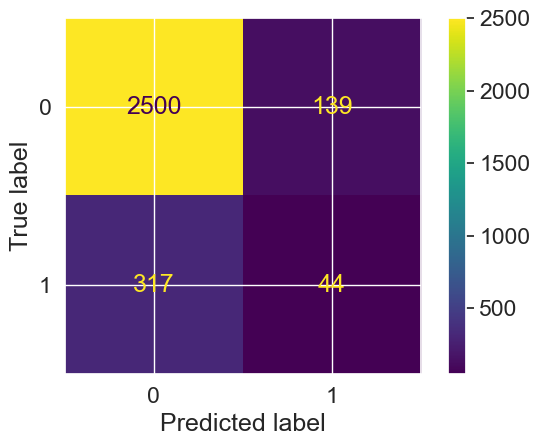

In [60]:
model_evaluation(xgb_opt, X_2_bal, X_test, y_2_bal, y_test, 'XGBoost')

## Feature importance<a id='feature_importance'>

Text(0.5, 0, 'score')

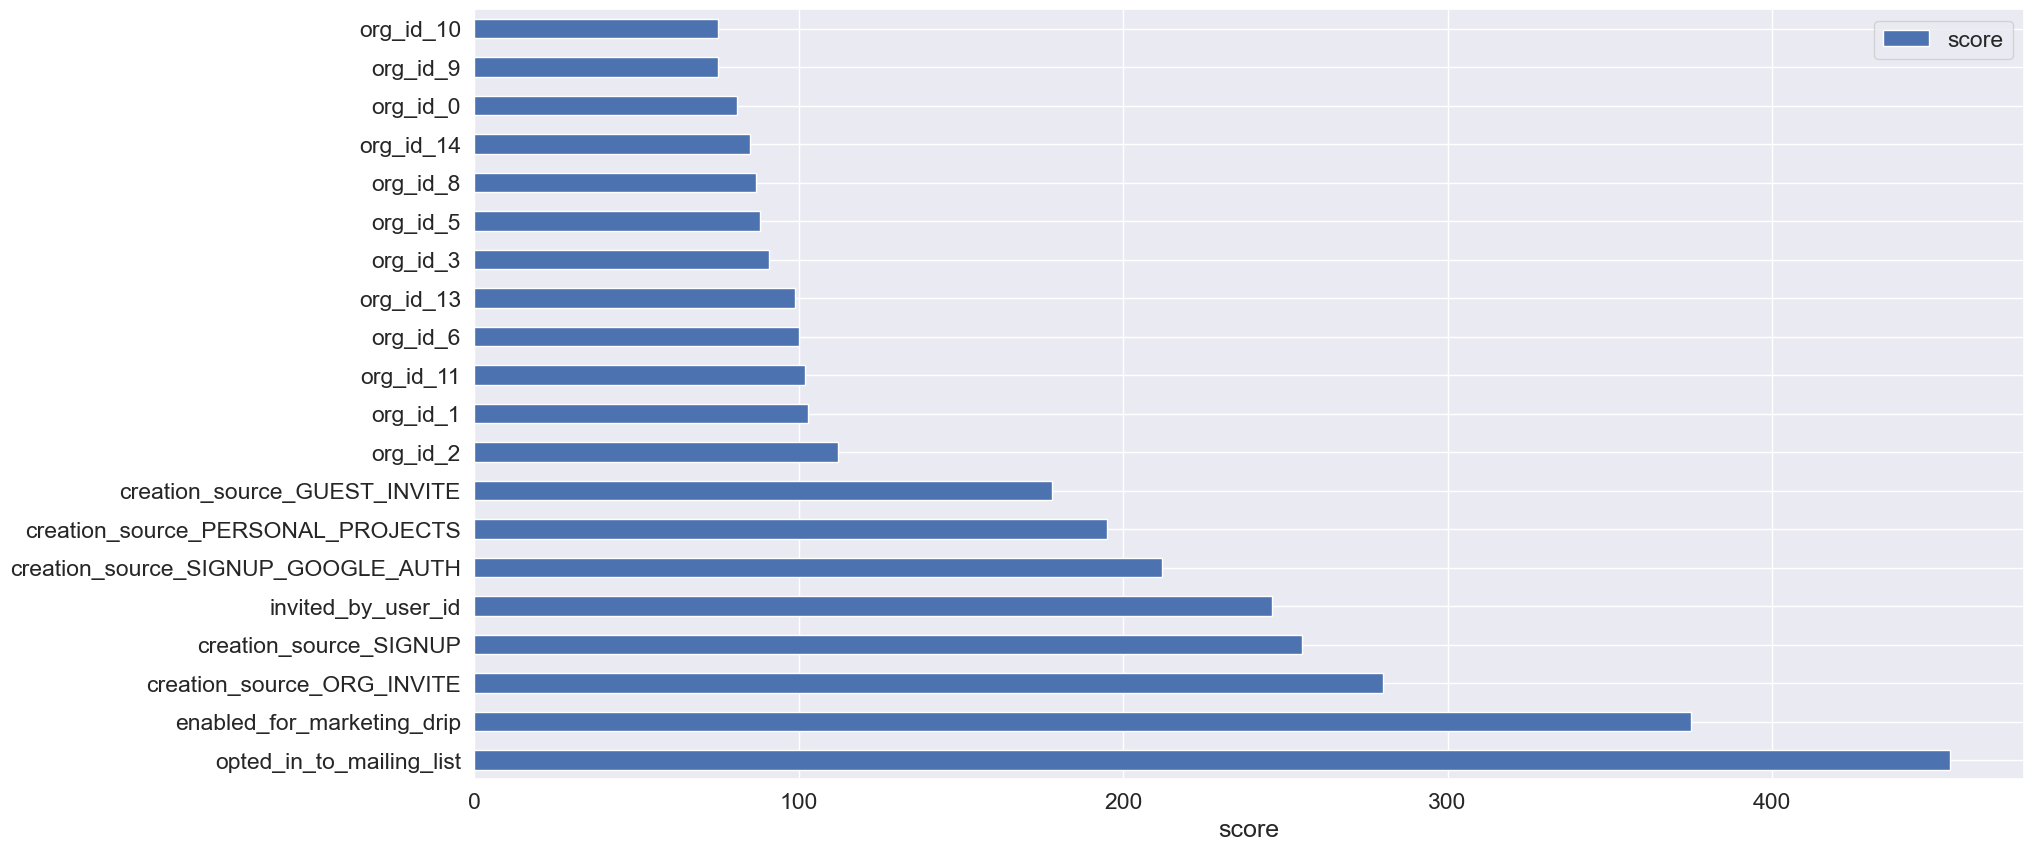

In [63]:
feature_important = xgb_opt.get_booster().get_score(importance_type='weight')
keys = list(feature_important.keys())
values = list(feature_important.values())

data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
data.nlargest(20, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features
plt.xlabel("score")

Based on the above feature importance chart, these users tend to remain active who come by these methods such  mailig_list,marketing_drip, creation_source_ORG_invite which are the three top most feature imortances. 